## Randomised Ensembled Double Q-Learning (REDQ)
This notebook implements the Randomised Ensembled Double Q-Learning (REDQ) model from scratch in PyTorch, comparing it to a D3QN baseline.

## Two Problems with DQN
#### Q-Value Overestimation
Arguably the most significant problem when training DQN-based models is the overestimation of Q-values. This occurs because Q-value estimations are updated by bootstrapping the maximum predicted Q-value from the next state. However, at the beginning of training, Q-values are determined purely by randomly initialised network weights. This reliance on greedily choosing the maximum Q-value from an immature, randomly initialised model can lead to the overestimation of future states. Bias arises because the model initially selects actions based on noisy estimates rather than proven outcomes. As these overestimations accumulate, they can destabilise training by reinforcing incorrect estimations of Q-values.

To mitigate Q-value overestimation, modifications like the use of infrequent target network updates and the double DQN approach have been introduced. The target network helps stabilise training by providing a more consistent basis for bootstrapping Q-value estimates, while double DQN separates the action selection from value estimation to further reduce bias. However while helpful, these modifications do not completely eliminate overestimation and introduce additional complexity. Managing this complexity the tuning of hyperparameters, most notably the frequency of target network updates.

#### Low Update-To-Data Ratio
This problem isn’t unique to DQN but affects all model-free RL algorithms. A low update-to-data (UTD) ratio indicates that each experience is used for learning only once or a few times before being discarded. Although learning from each experience more intensively may improve sample efficiency, it could just as easily bias the model toward those individual experiences. This highlights the challenge of balancing sample efficiency with exposure to a diverse range of experiences. 

DQN addresses this through the use of an experience replay buffer, which improves sample efficiency by allowing the agent to learn from past experiences multiple times, whilst simultaneously learning from a large batch of diverse experiences. The main drawback with this approach however is that as these stored experiences age, they can become less relevant or too far off-policy, potentially hindering learning. While off-policy algorithms generally have better UTD ratios than on-policy ones, DQN’s UTD ratio still remains substantially lower than what's possible in model-based approaches.

## DQN Implementation
Below is my implementation of D3QN which we'll use as a baseline model. It features the [double DQN](https://arxiv.org/abs/1509.06461), [dueling networks](https://arxiv.org/abs/1511.06581), multi-step reward calculation and global gradient norm clipping. Several components from this model will be reused by our REDQ agent.

### Q-Networks
Two simple Q-networks, a conventional one and a dueling variant.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)            
        )
        
    def forward(self, x):
        return self.network(x)

class DuelingQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.value = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.advantage = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )
        
    def forward(self, x):
        x = self.base(x)
        value = self.value(x)
        advantages = self.advantage(x)

        # Combine value and advantages to get final Q-values
        # Using the formula: Q(s, a) = V(s) + (A(s, a) - mean(A(s, a)))
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

### Linear Scheduler
Used to manage the annealing of $\epsilon$ in our model.

In [2]:
class LinearScheduler:
    "Used to create variables whose values are linearly annealed over time."
    def __init__(self, start, end, total_duration, fraction=1.):
        self.start = start
        self.end = end
        self.total_duration = total_duration
        self.duration = int(total_duration * fraction)
        self.step = 0
        
    def get(self):
        "Gets current value without incrementing step counter."
        if self.step < self.duration:
            current_value = self.start + (self.end - self.start) * (self.step / self.duration)
        else:
            current_value = self.end
        return current_value

    def __call__(self):
        "Gets current value and increments step counter."
        current_value = self.get()
        self.step += 1
        return current_value

### Replay Buffer
This buffer is designed to work for both single and multiple step reward calculation, using the new Gym API.

In [3]:
import numpy as np
import torch
from collections import deque

class ReplayBuffer:
    def __init__(self, capacity, num_steps=1, gamma=0.99):
        self.buffer = deque(maxlen=capacity)
        self.num_steps = num_steps
        self.gamma = gamma
        self.n_step_buffer = deque(maxlen=num_steps)
        
    def add(self, transition):
        "Pushes transition to buffer and handles n-step logic if required."
        assert len(transition) == 6, "Use new Gym step API: (s, a, r, s', ter, tru)"
        if self.num_steps == 1:
            state, action, reward, next_state, terminated, _ = transition
            self.buffer.append((state, action, reward, next_state, terminated))
        else:
            self.n_step_buffer.append(transition)
            
            # Calculate n-step reward
            _, _, _, final_state, final_termination, final_truncation = transition
            n_step_reward = 0.
            for _, _, reward, _, _, _ in reversed(self.n_step_buffer):
                  n_step_reward = n_step_reward * self.gamma + reward
            state, action, _, _, _, _ = self.n_step_buffer[0]

            # If n-step buffer is full, append to main buffer
            if len(self.n_step_buffer) == self.num_steps:
                self.buffer.append((state, action, n_step_reward, final_state, final_termination))
            
            # If done, clear n-step buffer
            if final_termination or final_truncation:
                self.n_step_buffer.clear()
        
    def sample(self, batch_size):
        "Samples a batch of experiences for learner to learn from."
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        states      = torch.tensor(np.stack(states),      dtype=torch.float32)
        actions     = torch.tensor(actions,               dtype=torch.int64  )
        rewards     = torch.tensor(rewards,               dtype=torch.float32)
        next_states = torch.tensor(np.stack(next_states), dtype=torch.float32)
        dones       = torch.tensor(dones,                 dtype=torch.float32)
        return states, actions, rewards, next_states, dones
        
    def __len__(self):
        return len(self.buffer)

### D3QN Agent
This class holds all of the logic for the training of our D3QN agent.

In [4]:
import numpy as np
import torch
import random
import gymnasium as gym
import time

class D3QN:
    def __init__(self, config):
        self.device = config['device']
        self.env = gym.make(config['env_name'])
        state_dim = np.prod(self.env.observation_space.shape)
        action_dim = self.env.action_space.n
        NetworkClass = DuelingQNetwork if config['dueling'] else QNetwork
        self.online_network = NetworkClass(state_dim, action_dim, config['hidden_dim']).to(self.device)
        self.target_network = NetworkClass(state_dim, action_dim, config['hidden_dim']).to(self.device)
        self.update_target_network(1.)
        self.optimizer = torch.optim.Adam(self.online_network.parameters(), lr=config['lr'])
        self.buffer = ReplayBuffer(config['buffer_capacity'], config['num_steps'], config['gamma'])
        self.epsilon = LinearScheduler(config['eps_start'], config['eps_final'], 
                                       config['total_steps'], config['eps_fraction'])
        self.config = config
        
    def select_action(self, state, epsilon):
        "Epsilon greedy action selection."
        if random.random() < epsilon:
            return self.env.action_space.sample()
        state_tensor = torch.tensor(state, device=self.device).unsqueeze(0)
        return self.online_network(state_tensor).argmax().item()
    
    def update_target_network(self, tau):
        "Updates the parameters of the target network, tau controls how fully the weights are copied."
        for target_param, online_param in zip(self.target_network.parameters(), self.online_network.parameters()):
            target_param.data.copy_(tau * online_param.data + (1. - tau) * target_param.data)
    
    def learn(self):
        "Perform a single learning step."
        # Sample experience data
        experiences = self.buffer.sample(self.config['batch_size'])
        
        # Expand experience data and move to device
        states, actions, rewards, next_states, dones = experiences
        states = states.to(self.device)
        actions = actions.to(self.device).unsqueeze(1)
        rewards = rewards.to(self.device).unsqueeze(1)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device).unsqueeze(1)

        # Predicted Q-values for current state
        current_state_q = self.online_network(states)
        
        # Gather Q-values of actions actually taken
        current_action_q = torch.gather(current_state_q, dim=1, index=actions)
        
        # Calculate target
        with torch.no_grad():
            # Boostrap from target network
            next_state_q = self.target_network(next_states)
            
            if self.config['double_dqn']:
                # Select action index from target network based on greatest state-action value from online network
                next_state_best_actions = torch.argmax(self.online_network(next_states), dim=1, keepdims=True)
                next_state_max_q = torch.gather(next_state_q, dim=1, index=next_state_best_actions)
            else:
                # Select action index based on greatest state-action value from target network
                next_state_max_q = torch.max(next_state_q, dim=1, keepdims=True)[0]
            
            # Unrolled Bellman equation to compute target Q-values
            target_q = rewards + self.config['gamma'] ** self.config['num_steps'] * (1. - dones) * next_state_max_q
        
        # Weighted loss calculation with MSE
        loss = F.mse_loss(current_action_q, target_q)
        
        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.online_network.parameters(), self.config['grad_norm_clip'])
        self.optimizer.step()
    
    def train(self):
        "Trains agent for a given number of steps according to given configuration."
        if self.config['verbose']: print("Training agent\n")
        
        # Logging information
        logs = {'episode_count': 0, 'episodic_reward': 0., 'episode_rewards': [], 'start_time': time.time()}
        
        # Reset episode
        state, _ = self.env.reset()
        
        # Main training loop
        for step in range(1, self.config['total_steps'] + 1):
            # Get action and step in envrionment
            action = self.select_action(state, self.epsilon())
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            
            # Update logs
            logs['episodic_reward'] += reward
            
            # Push experience to buffer
            self.buffer.add((state, action, reward, next_state, terminated, truncated))

            if terminated or truncated:
                state, _ = self.env.reset()
                
                # Update logs
                logs['episode_count'] += 1
                logs['episode_rewards'].append(logs['episodic_reward'])
                logs['episodic_reward'] = 0.
            else:
                state = next_state
            
            # Perform learning step
            if len(self.buffer) > self.config['batch_size'] and step >= self.config['learning_starts']:
                self.learn()
            
            # Update target network
            if step % self.config['target_update'] == 0:
                self.update_target_network(self.config['tau'])
                
            # If mean of last 20 rewards exceed target, end training
            if len(logs['episode_rewards']) > 0 and np.mean(logs['episode_rewards'][-20:]) >= self.config['target_reward']:
                break
            
            # Print training info if verbose
            if self.config['verbose'] and step % 100 == 0 and len(logs['episode_rewards']) > 0:
                print(f"\r--- {100 * step / self.config['total_steps']:.1f}%" 
                      f"\t Step: {step:,}"
                      f"\t Mean Reward: {np.mean(logs['episode_rewards'][-20:]):.2f}"
                      f"\t Epsilon: {self.epsilon.get():.2f}"
                      f"\t Episode: {logs['episode_count']:,}"
                      f"\t Duration: {time.time() - logs['start_time']:,.1f}s  ---", end='')
                if step % 10000 == 0:
                    print()
                    
        # Training ended
        if self.config['verbose']: print("\n\nTraining done")
        logs['end_time'] = time.time()
        logs['duration'] = logs['end_time'] - logs['start_time']
        return logs

### D3QN Config

In [5]:
d3qn_config = {
    'env_name'       : 'CartPole-v1',  # Environment name
    'device'         :         'cuda',  # Device DQN runs on
    'total_steps'    :        100000,  # Total training steps
    'target_reward'  :           195,  # Target reward to stop training at when reached
    'eps_start'      :           0.6,  # Initial epsilon value
    'eps_final'      :          0.05,  # Lowest possible epsilon value
    'eps_fraction'   :           0.7,  # Fraction of total time epsilon is annealed over
    'gamma'          :          0.99,  # Discount Factor 
    'lr'             :          5e-4,  # Learning rate
    'hidden_dim'     :            64,  # Number of neurons in hidden layers
    'batch_size'     :            64,  # Batch size used by learner
    'buffer_capacity':        100000,  # Maximum replay buffer capacity
    'target_update'  :            50,  # Target network update interval
    'tau'            :            1.,  # Soft target network update interpolation coefficient
    'learning_starts':           256,  # Begin learning after performing this many steps
    'num_steps'      :             3,  # Number of steps to unroll Bellman equation by
    'dueling'        :          True,  # Dueling networks tweak
    'double_dqn'     :          True,  # Double DQN tweak
    'grad_norm_clip' :            10,  # Global gradient clipping value
    'verbose'        :          False,  # Verbose printing
}

### Train D3QN Agent

In [6]:
evaluation_runs = 20
dqn_logs = []
for idx in range(evaluation_runs):
    print(f'\r{idx}/{evaluation_runs}', end='')
    dqn = D3QN(d3qn_config)
    dqn_logs.append(dqn.train())

19/20

### Plot Results

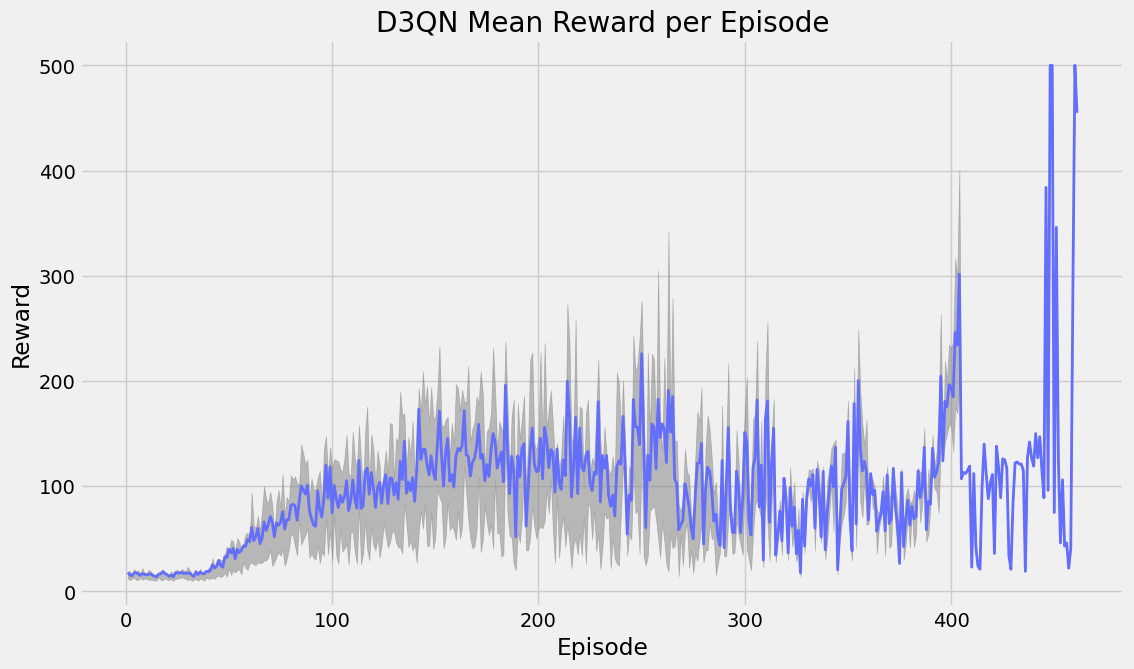

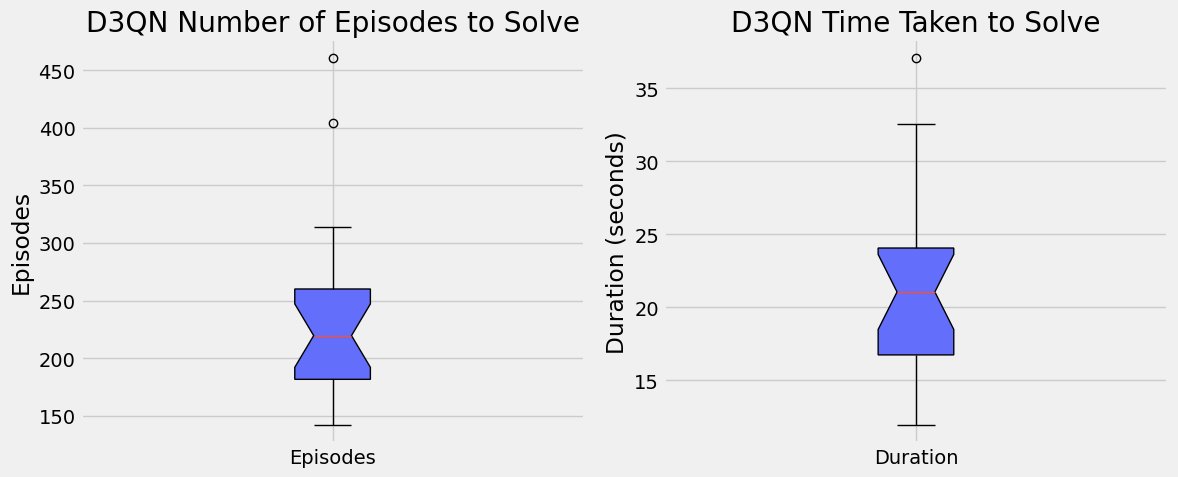

In [7]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

def plot_mean_rewards_with_iqr(logs, color, model_name):
    "Plots rewards per episode from a list of logs dictionaries."
    max_episodes = max(log['episode_count'] for log in logs)
    all_rewards = np.zeros((len(logs), max_episodes))
    
    # Populate the reward matrix, each row is a run, each column an episode
    for idx, log in enumerate(logs):
        rewards = np.array(log['episode_rewards'])
        all_rewards[idx, :len(rewards)] = rewards
        if len(rewards) < max_episodes:
            all_rewards[idx, len(rewards):] = np.nan  # Fill remaining episodes with NaN for runs that ended early
    
    # Calculate mean and IQR across runs
    mean_rewards = np.nanmean(all_rewards, axis=0)
    q75, q25 = np.nanpercentile(all_rewards, [75, 25], axis=0)
    
    # Plotting
    episodes = np.arange(1, max_episodes + 1)
    plt.figure(figsize=(12, 7))
    plt.plot(episodes, mean_rewards, lw=2, c=color)
    plt.fill_between(episodes, q25, q75, color='grey', alpha=0.5)
    
    plt.title(f'{model_name} Mean Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

def plot_episodes_and_duration_boxplots(logs, color, model_name):
    episodes = [log['episode_count'] for log in logs]
    durations = [log['duration'] for log in logs]
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    
    # Creating the boxplot for episodes
    bp_episodes = axs[0].boxplot(episodes, notch=True, patch_artist=True)
    axs[0].set_title(f'{model_name} Number of Episodes to Solve')
    axs[0].set_ylabel('Episodes')
    axs[0].set_xticklabels(['Episodes'])
    
    # Creating the boxplot for durations
    bp_durations = axs[1].boxplot(durations, notch=True, patch_artist=True)
    axs[1].set_title(f'{model_name} Time Taken to Solve')
    axs[1].set_ylabel('Duration (seconds)')
    axs[1].set_xticklabels(['Duration'])

    # Setting custom colors
    for box in bp_episodes['boxes']:
        box.set_facecolor(color)
    for box in bp_durations['boxes']:
        box.set_facecolor(color)

    plt.tight_layout()
    plt.show()

plot_mean_rewards_with_iqr(dqn_logs, color='#636EFA', model_name='D3QN')
plot_episodes_and_duration_boxplots(dqn_logs, color='#636EFA', model_name='D3QN')

#### Thoughts:
- Experimentally, this agent typically solves CartPole in 200-300 episodes, or around 18,000-24,000 steps.
- Each solve can take anywhere between 15-25 seconds on CPU.

## Introduction to REDQ
REDQ is a simple model-free DQN variant that learns with an ensemble of Q-networks, rather than learning with a single online network and single taget network. This approach offers the following benefits:

- To reduce variance in the Q-function estimate, REDQ uses an ensemble of $N$ Q-functions, with each Q-function randmly and independently initialised but updated with the same target.

- To reduce over-estimation bias, the target for the Q-function includes a minimisation over a *random subset* $\mathcal{M}$ of the $N$ Q-functions. The size of the subset $\mathcal{M}$ is kept fixed, and is denoted as $M$, and is referred to as the *in-target minimisation parameter*. 

- To improve sample efficiency, the UTD ratio $G$ is much greater than one.

Since the authors' default choice for $M$ is $M = 2$, they refer to the algorithm as Randomised Ensembled *Double* Q-learning (REDQ).

### REDQ Algorithm
The original paper uses REDQ in SAC, but we'll modify it for use with DQN:

**for** $G$ updates **do**

- Sample a mini-batch $B = \{(s, a, r, s')\}$ from $\mathcal{D}$
- Sample a set $\mathcal{M}$ of M distinct indices from $\{1, 2, ..., N\}$
- Compute the Q target $y$ (same for all of the N Q-functions):
    
    $y = r + \gamma \left(\min_{i \in \mathcal{M}}Q_{\phi_{\text{targ, i}}} (s', \text{argmax}_{a'} Q_{\phi_i} (s', a')) \right)$
    
    **for** $i = 1, ..., N$ **do**
    - Update $\phi_i$ with gradient descent using 
    
    $\;\;\; \nabla_\phi \frac{1}{|B|} \sum_{(s, a, r, s') \in B} \left(Q_{\phi_i} (s, a) - y^2\right)$
    
    - Update target networks with $\phi_{\text{targ, i}} \leftarrow (1 - \tau) \phi_{\text{targ, i}} + \tau \phi_i$

In simpler terms;
- We perform multiple learning steps per environment step.
- Every learning step we update the parameters of every online network in the ensemble once.
- The Q-target is chosen as the minimum, maximum Q-value in the current state sampled from a subset of the target networks.
- Every time we update the parameters, we perform a soft target network update.

## REDQ Agent
Below we implement the REDQ agent, using our D3QN agent as the base model.

In [8]:
class REDQ:
    def __init__(self, config):
        self.device = config['device']
        self.env = gym.make(config['env_name'])
        state_dim = np.prod(self.env.observation_space.shape)
        action_dim = self.env.action_space.n
        
        # Create networks and optimisers
        NetworkClass = DuelingQNetwork if config['dueling'] else QNetwork
        self.online_networks, self.target_networks, self.optimizers = {}, {}, {}
        for idx in range(config['N']):
            self.online_networks[idx] = NetworkClass(state_dim, action_dim, config['hidden_dim']).to(self.device)
            self.target_networks[idx] = NetworkClass(state_dim, action_dim, config['hidden_dim']).to(self.device)
            self.target_networks[idx].load_state_dict(self.online_networks[idx].state_dict())
            self.optimizers[idx] = torch.optim.Adam(self.online_networks[idx].parameters(), lr=config['lr'])
            
        self.buffer = ReplayBuffer(config['buffer_capacity'], config['num_steps'], config['gamma'])
        self.epsilon = LinearScheduler(config['eps_start'], config['eps_final'], 
                                       config['total_steps'], config['eps_fraction'])
        self.config = config
        
    def select_action(self, state, epsilon):
        "Epsilon greedy action selection from a random Q-network."
        if random.random() < epsilon:
            return self.env.action_space.sample()
        state_tensor = torch.tensor(state, device=self.device).unsqueeze(0)
        network = self.online_networks[random.choice(range(self.config['N']))]
        return network(state_tensor).argmax().item()
    
    def soft_update(self, online_network, target_network, tau):
        "Updates the parameters of an online + target network pair, tau controls how fully the weights are copied."
        for target_param, online_param in zip(target_network.parameters(), online_network.parameters()):
            target_param.data.copy_(tau * online_param.data + (1. - tau) * target_param.data)
            
    def learn(self):
        "Perform a single learning step."
        # Sample experience data
        experiences = self.buffer.sample(self.config['batch_size'])
        
        # Expand experience data and move to device
        states, actions, rewards, next_states, dones = experiences
        states = states.to(self.device)
        actions = actions.to(self.device).unsqueeze(1)
        rewards = rewards.to(self.device).unsqueeze(1)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device).unsqueeze(1)
        
        # Target networks used for next state Q calculation
        target_network_indices = random.sample(range(self.config['N']), self.config['M'])
        
        # Calculate target
        with torch.no_grad():
            # Predicted Q-values for each target network
            next_state_qs = torch.stack([self.target_networks[idx](states) for idx in target_network_indices])
            
            # Maximum predicted action value for each state
            next_state_max_qs = torch.max(next_state_qs, dim=2, keepdims=True)[0]
            
            # Minimum of these predicted action values
            next_state_min_max_q = next_state_max_qs.min(dim=0)[0]
            
            # Unrolled Bellman equation for full target
            target_q = rewards + self.config['gamma'] ** self.config['num_steps'] * (1. - dones) * next_state_min_max_q
        
        # Update each online network and do soft target network update
        for idx in range(self.config['N']):
            # Predict Q-value for current state and chosen action
            current_state_q = self.online_networks[idx](states)
            current_action_q = torch.gather(current_state_q, dim=1, index=actions)
            
            # Loss calculation with MSE
            loss = F.mse_loss(current_action_q, target_q)
            
            # Backward pass
            self.optimizers[idx].zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.online_networks[idx].parameters(), self.config['grad_norm_clip'])
            self.optimizers[idx].step()
            
            # Soft update target network parameters
            self.soft_update(self.online_networks[idx], self.target_networks[idx], self.config['tau'])
        
    def train(self):
        "Trains agent for a given number of steps according to given configuration."
        if self.config['verbose']: print("Training agent\n")
        
        # Logging information
        logs = {'episode_count': 0, 'episodic_reward': 0., 'episode_rewards': [], 'start_time': time.time()}
        
        # Reset episode
        state, _ = self.env.reset()
        
        # Main training loop
        for step in range(1, self.config['total_steps'] + 1):
            # Get action and step in envrionment
            action = self.select_action(state, self.epsilon())
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            
            # Update logs
            logs['episodic_reward'] += reward
            
            # Push experience to buffer
            self.buffer.add((state, action, reward, next_state, terminated, truncated))

            if terminated or truncated:
                state, _ = self.env.reset()
                
                # Update logs
                logs['episode_count'] += 1
                logs['episode_rewards'].append(logs['episodic_reward'])
                logs['episodic_reward'] = 0.
            else:
                state = next_state
            
            # Perform several learning step
            if len(self.buffer) > self.config['batch_size'] and step >= self.config['learning_starts']:
                for _ in range(self.config['G']):
                    self.learn()
            
            # If mean of last 20 rewards exceed target, end training
            if len(logs['episode_rewards']) > 0 and np.mean(logs['episode_rewards'][-20:]) >= self.config['target_reward']:
                break
            
            # Print training info if verbose
            if self.config['verbose'] and step % 100 == 0 and len(logs['episode_rewards']) > 0:
                print(f"\r--- {100 * step / self.config['total_steps']:.1f}%" 
                      f"\t Step: {step:,}"
                      f"\t Mean Reward: {np.mean(logs['episode_rewards'][-20:]):.2f}"
                      f"\t Epsilon: {self.epsilon.get():.2f}"
                      f"\t Episode: {logs['episode_count']:,}"
                      f"\t Duration: {time.time() - logs['start_time']:,.1f}s  ---", end='')
                if step % 1000 == 0:
                    print()
                    
        # Training ended
        if self.config['verbose']: print("\n\nTraining done")
        logs['end_time'] = time.time()
        logs['duration'] = logs['end_time'] - logs['start_time']
        return logs

### REDQ Config

In [9]:
redq_config = {
    'env_name'       : 'CartPole-v1',  # Environment name
    'device'         :         'cuda',  # Device DQN runs on
    'total_steps'    :         10000,  # Total training steps
    'target_reward'  :           195,  # Target reward to stop training at when reached
    'eps_start'      :           0.6,  # Initial epsilon value
    'eps_final'      :          0.05,  # Lowest possible epsilon value
    'eps_fraction'   :           0.7,  # Fraction of total time epsilon is annealed over
    'gamma'          :          0.99,  # Discount Factor 
    'lr'             :          1e-4,  # Learning rate
    'hidden_dim'     :            32,  # Number of neurons in hidden layers
    'batch_size'     :            32,  # Batch size used by learner
    'buffer_capacity':        100000,  # Maximum replay buffer capacity
    'tau'            :         0.005,  # Soft target network update interpolation coefficient
    'learning_starts':           128,  # Begin learning after performing this many steps
    'num_steps'      :             3,  # Number of steps to unroll Bellman equation by
    'dueling'        :          True,  # Dueling networks tweak
    'grad_norm_clip' :            10,  # Global gradient clipping value
    'verbose'        :         False,  # Verbose printing
    
    # REDQ specific settings
    'N'              :            10,  # Ensemble size
    'M'              :             2,  # Number of target networks used in each Q target calculation
    'G'              :            10,  # Number of learning updates per environment step
}

### Train REDQ

In [10]:
redq_logs = []
for idx in range(evaluation_runs):
    print(f'\r{idx}/{evaluation_runs}', end='')
    redq = REDQ(redq_config)
    redq_logs.append(redq.train())

19/20

### Plot Results

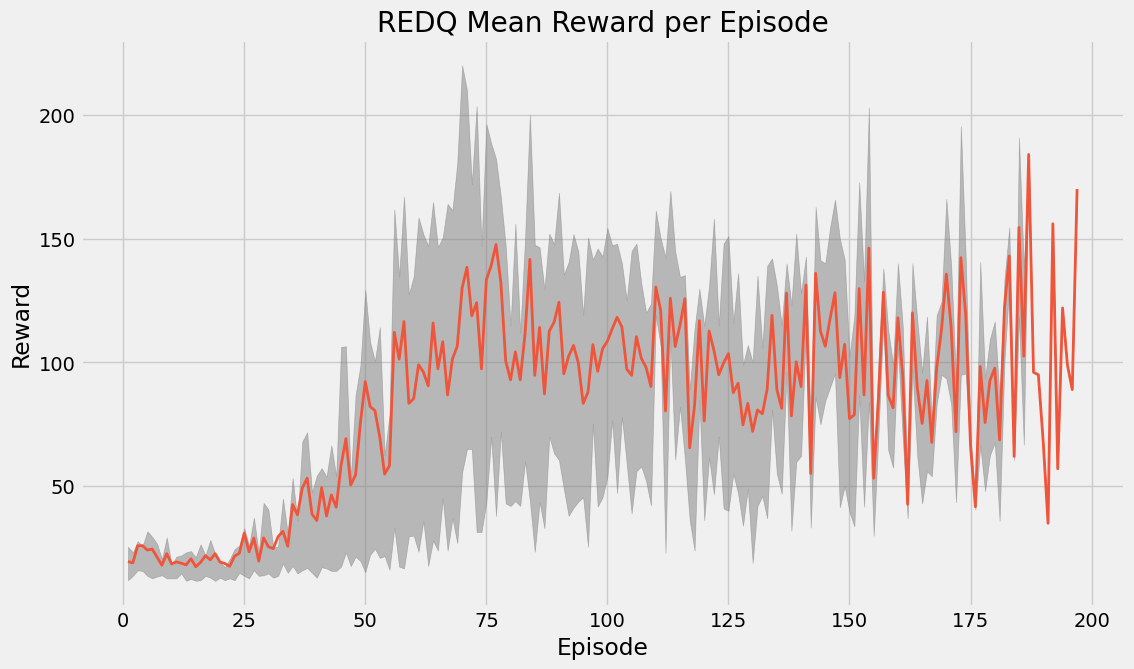

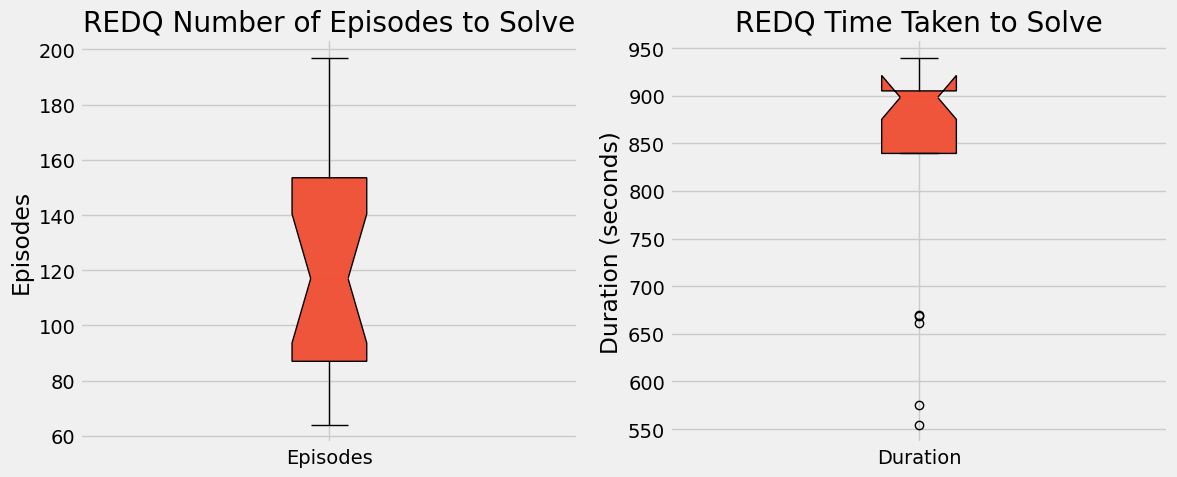

In [11]:
plot_mean_rewards_with_iqr(redq_logs, color='#EF553B', model_name='REDQ')
plot_episodes_and_duration_boxplots(redq_logs, color='#EF553B', model_name='REDQ')

#### Thoughts:
- REDQ solves CartPole in typically 90-150 episodes, which is approximately twice as sample efficient as D3QN.
- It took far more time than D3QN to solve the environment however, needing more than 15 minutes per solve on GPU.